In [13]:
import sqlite3
import pandas as pd

# load dataframe
dfs = []
with sqlite3.connect('./db/database.db') as cnx:
    try:
        dfs.append(pd.read_sql_query("SELECT * FROM ratings", cnx))
    except:
        print("Unable to get historical data")
        exit(1)
    try:
        dfs.append(pd.read_sql_query("SELECT * FROM new_ratings", cnx))
    except:
        print("No new data")

df = pd.concat(dfs)
print("rows: ", df.shape, df.columns)

No new data
rows:  (100836, 4) Index(['userId', 'movieId', 'rating', 'timestamp'], dtype='object')


<Axes: xlabel='rating', ylabel='count'>

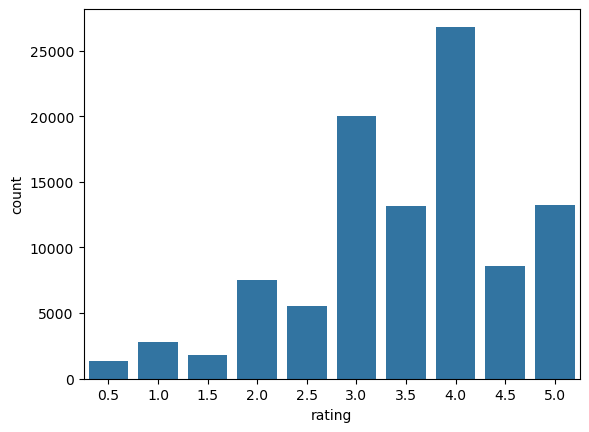

In [18]:
import seaborn as sns

rating_data = df

sns.barplot(x=rating_data['rating'].value_counts().index, y=rating_data['rating'].value_counts())



In [14]:
from surprise import Dataset
from surprise import Reader
from surprise import SVD
from surprise.model_selection import cross_validate

rating_data = df

reader = Reader(rating_scale=(0.5, 5))
data = Dataset.load_from_df(rating_data[['userId', 'movieId', 'rating']], reader)

# trainset, testset = train_test_split(data, test_size=.20)
trainset = data.build_full_trainset()
algo = SVD()
cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

algo.fit(data.build_full_trainset())
predictions = algo.test(trainset.build_anti_testset())
predictions[0:100:20]



Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8791  0.8782  0.8670  0.8733  0.8754  0.8746  0.0043  
MAE (testset)     0.6752  0.6755  0.6655  0.6701  0.6732  0.6719  0.0037  
Fit time          0.49    0.47    0.47    0.45    0.42    0.46    0.03    
Test time         0.05    0.05    0.04    0.04    0.04    0.04    0.00    


[Prediction(uid=1, iid=318, r_ui=3.501556983616962, est=4.99037768541556, details={'was_impossible': False}),
 Prediction(uid=1, iid=106782, r_ui=3.501556983616962, est=4.7823149700990095, details={'was_impossible': False}),
 Prediction(uid=1, iid=2288, r_ui=3.501556983616962, est=4.674140999235998, details={'was_impossible': False}),
 Prediction(uid=1, iid=32, r_ui=3.501556983616962, est=4.952551177777131, details={'was_impossible': False}),
 Prediction(uid=1, iid=351, r_ui=3.501556983616962, est=4.148309167382527, details={'was_impossible': False})]

In [15]:

import time
from collections import defaultdict

top_n = defaultdict(list)
for uid, iid, true_r, est, _ in predictions:
  top_n[uid].append((iid, est))

k = 5
for uid, user_ratings in top_n.items():
  user_ratings.sort(key=lambda x: x[1], reverse=True)
  top_n[uid] = user_ratings[:k]
print("Recommendations")
print("-" * 80)
for uid, user_ratings in list(top_n.items())[:10]:
  items = [iid for (iid, _) in user_ratings]
  print(f"UserId {uid}\tmovieIds: {items}")

now = int(time.time()) # seconds since epoch
with sqlite3.connect('./db/database.db') as cnx:
  cnx.execute("CREATE TABLE IF NOT EXISTS recommendations (userId INT, movieId INT, rating REAL, timestamp INT)")
  for idx, [uid, user_ratings] in enumerate(top_n.items()):
    for (iid, rating) in user_ratings:
      cnx.execute(f"INSERT INTO recommendations (userId, movieId, rating, timestamp) VALUES ({uid}, {iid}, {rating}, {now})")



Recommendations
--------------------------------------------------------------------------------
UserId 1	movieIds: [68157, 79132, 112552, 720, 898]
UserId 2	movieIds: [904, 1204, 930, 908, 56782]
UserId 3	movieIds: [1203, 5008, 1206, 7361, 912]
UserId 4	movieIds: [913, 750, 148626, 858, 1276]
UserId 5	movieIds: [1204, 1136, 1250, 246, 912]
UserId 6	movieIds: [951, 56782, 78499, 2791, 1237]
UserId 7	movieIds: [296, 1213, 1258, 1204, 115713]
UserId 8	movieIds: [1221, 2160, 5618, 4226, 1178]
UserId 9	movieIds: [1204, 246, 750, 1272, 260]
UserId 10	movieIds: [72226, 909, 104879, 1198, 48516]
